# Accelerating FiPy with `pyamgx`

This notebook demonstrates how `pyamgx` can be used to speed up the [`FiPy`](https://www.ctcms.nist.gov/fipy/) finite volume code. The speed-up results from using the GPU-accelerated sparse solvers from the NVIDIA [AmgX](https://github.com/NVIDIA/AMGX) library.

All tests are performed on a compute node with an NVIDIA Tesla P-100 GPU (there are 2 per node, but only one is used), and a 28-core Intel Xeon processor.

In [1]:
!nvidia-smi

Thu Apr 26 07:33:23 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.98                 Driver Version: 384.98                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:02:00.0 Off |                    0 |
| N/A   19C    P0    30W / 250W |     24MiB / 12193MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:82:00.0 Off |                    0 |
| N/A   16C    P0    23W / 250W |     24MiB / 12193MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## Example 1: 2-D steady-state diffusion equation

This example is taken from the FiPy examples listed [here](https://www.ctcms.nist.gov/fipy/examples/diffusion/index.html).

We consider solving the 2-D steady-state diffusion equation $ \nabla^2 \phi = 0 $ on a square grid. Dirichlet boundary conditions are applied to the top-left and bottom-right corners. Neumann boundary conditions are automatically applied to the bottom-left and top-right corners. 

The function `setup_phi` below sets up the initial values and boundary conditions for the variable $\phi$. Note that the initial value of $\phi$ is set to zero at each grid point.

In [2]:
from fipy import *

def setup_phi(N):
    nx = N
    ny = nx
    dx = 1.
    dy = dx
    L = dx * nx
    mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

    phi = CellVariable(name = "solution variable $\phi$",
                       mesh = mesh,
                       value = 0.0) # `value` specifies the initial values

    valueTopLeft = 0
    valueBottomRight = 1

    X, Y = mesh.faceCenters
    facesTopLeft = ((mesh.facesLeft & (Y > L / 2))
                     | (mesh.facesTop & (X < L / 2)))
    facesBottomRight = ((mesh.facesRight & (Y < L / 2))
                         | (mesh.facesBottom & (X > L / 2)))

    phi.constrain(valueTopLeft, facesTopLeft)
    phi.constrain(valueBottomRight, facesBottomRight)
    return phi

First, we define $\phi$ on a 1000x1000 grid:

In [3]:
phi = setup_phi(1000)

Next, we construct the diffusion equation consisting of the term  $ \nabla^2 \phi $.

In [4]:
eq = DiffusionTerm()

The `eq` object represents the discretization of the diffusion equation, which will result in a system of linear equations. The solution of this (sparse) linear system gives the values of $\phi$ at the grid points.

In [5]:
%%timeit -n1 -r1
eq.solve(var=phi)

7.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The solution can be visualized using a FiPy `Viewer`:

In [6]:
viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='hot')

We note that the solution took about 7 seconds using the default settings. What solver was used?

In [7]:
print(DefaultSolver)

<class 'fipy.solvers.pyAMG.linearGMRESSolver.LinearGMRESSolver'>


The default solver is the GMRES solver from the [pyAMG](http://code.google.com/p/pyamg/) package. To compare, let's use a different solver (CGS solver from the SciPy package):

In [8]:
from fipy.solvers.scipy import LinearCGSSolver

Before solving the equation again, it's important to reset the values of $\phi$:

In [9]:
phi.value = 0

The (optional) `solver` argument to the `solve` method allows us to specify the sparse solver to be used. Let's use the `LinearCGSSolver` imported above:

In [10]:
%%timeit -n1 -r1
eq.solve(var=phi, solver=LinearCGSSolver())

55.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


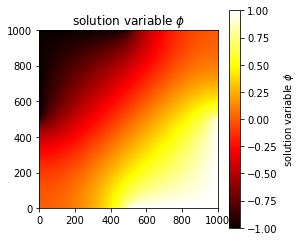

In [11]:
viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='hot')

Any of [FiPy's solvers](https://www.ctcms.nist.gov/fipy/documentation/SOLVERS.html) can be used with the `solver` argument above. All FiPy solvers are classes that inherit from a common abstract base-class `Solver`, allowing them to be used interchangeably. It's also possible to use a custom solver class, as long as it inherits from the `Solver` base-class, and provides the same interface as other FiPy solvers.

Below, we define a custom `PyAMGXSolver` class that serves as an interface to the AmgX library linear solvers. The `pyamgx` library is used to interface AmgX from Python. In addition to providing an interface to the AmgX solvers, `pyamgx` allows us to "upload" Numpy arrays and SciPy sparse matrices (which reside in CPU memory) to AmgX vectors and matrices (which reside on the GPU); and to "download" AmgX vectors back to NumPy arrays.

In [12]:
from fipy.solvers.solver import Solver
from fipy.matrices.scipyMatrix import _ScipyMeshMatrix
from fipy.tools import numerix

import numpy
from scipy.sparse import csr_matrix
import pyamgx
import os

class PyAMGXSolver(Solver):
    """
    The PyAMGXSolver class.
    """

    def __init__(self, config_dict, *args, **kwargs):
        """
        Parameters
        ----------
        config_dict : dict
            Dictionary specifying AMGX configuration options
        """
        self.config_dict = config_dict
        self.cfg = pyamgx.Config().create_from_dict(self.config_dict)
        self.resources = pyamgx.Resources().create_simple(self.cfg)
        self.x_gpu = pyamgx.Vector().create(self.resources)
        self.b_gpu = pyamgx.Vector().create(self.resources)
        self.A_gpu = pyamgx.Matrix().create(self.resources)
        self.solver = pyamgx.Solver().create(self.resources, self.cfg)

    @property
    def _matrixClass(self):
        return _ScipyMeshMatrix

    def _storeMatrix(self, var, matrix, RHSvector):
        self.var = var
        self.matrix = matrix
        self.RHSvector = RHSvector

        self.A_gpu.upload_CSR(self.matrix.matrix)
        self.solver.setup(self.A_gpu)

    def _solve_(self, L, x, b):
        # transfer data from CPU to GPU
        self.x_gpu.upload(x)
        self.b_gpu.upload(b)

        # solve system on GPU
        self.solver.solve(self.b_gpu, self.x_gpu)

        # download values from GPU to CPU
        self.x_gpu.download(x)

    def _solve(self):
        self._solve_(self.matrix, self.var.ravel(), numerix.array(self.RHSvector))
            
    def _canSolveAsymmetric(self):
        return False

    def destroy(self):
        self.A_gpu.destroy()
        self.b_gpu.destroy()
        self.x_gpu.destroy()
        self.solver.destroy()
        self.resources.destroy()
        self.cfg.destroy()

The `PyAMGXSolver` class accepts a dictionary containing solver configuration options as input. Examples of solver configurations can be found [here](https://github.com/NVIDIA/AMGX/tree/master/core/configs). To create a GMRES solver:

In [13]:
import pyamgx
pyamgx.initialize()

cfg_dict = {
    "config_version": 2, 
    "determinism_flag": 1,
    "exception_handling" : 1,
    "solver": {
        "print_grid_stats": 1, 
        "store_res_history": 1, 
        "solver": "GMRES", 
        "print_solve_stats": 1, 
        "obtain_timings": 1, 
        "preconditioner": {
            "interpolator": "D2", 
            "print_grid_stats": 1, 
            "solver": "AMG", 
            "smoother": "JACOBI_L1", 
            "presweeps": 2, 
            "selector": "PMIS", 
            "coarsest_sweeps": 2, 
            "coarse_solver": "NOSOLVER", 
            "max_iters": 1, 
            "interp_max_elements": 4, 
            "min_coarse_rows": 2, 
            "scope": "amg_solver", 
            "max_levels": 24, 
            "cycle": "V", 
            "postsweeps": 2
        }, 
        "max_iters": 100, 
        "monitor_residual": 1, 
        "gmres_n_restart": 10, 
        "convergence": "RELATIVE_INI_CORE", 
        "tolerance": 1e-06, 
        "norm": "L2"
   }
}

gmres = PyAMGXSolver(cfg_dict)

Let's solve the diffusion equation with this solver:

In [14]:
phi.value = 0 # reset the value of phi

In [15]:
%%timeit -n1 -r1
eq.solve(var=phi, solver=gmres)

2.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


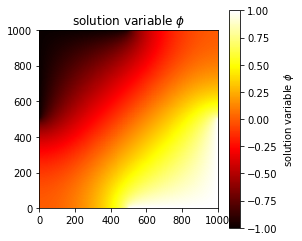

In [16]:
viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='hot')

We see that the solution is obtained in about 2.2 seconds. Below, we time the default FiPy solver and the custom PyAMGX solver for various problem sizes and plot the resulting speedups. At steady state, the value of $\phi$ at the center of the square is expected to be 0.5.

In [17]:
import time
default_solver_times = []
pyamgx_solver_times = []

for N in [100, 200, 500, 1000, 2000]:
    phi = setup_phi(N)
    t1 = time.time()
    DiffusionTerm().solve(var=phi)
    t2 = time.time()
    
    phi = setup_phi(N)
    t3 = time.time()
    DiffusionTerm().solve(var=phi, solver=gmres)
    t4 = time.time()
    
    default_solver_times.append(t2-t1)
    pyamgx_solver_times.append(t4-t3)
    print("N = {}".format(N))
    print("\t Time taken by default solver: {}".format(t2-t1))
    print("\t Time taken by pyamgx solver: {}".format(t4-t3))
    print("\t Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((N/2,), (N/2)))))

N = 100
	 Time taken by default solver: 0.11637711524963379
	 Time taken by pyamgx solver: 0.08561372756958008
	 Value of phi at (x, y) = (0.5, 0.5): [0.5000008]
N = 200
	 Time taken by default solver: 0.3544180393218994
	 Time taken by pyamgx solver: 0.1614387035369873
	 Value of phi at (x, y) = (0.5, 0.5): [0.50000176]
N = 500
	 Time taken by default solver: 1.598724603652954
	 Time taken by pyamgx solver: 0.7140552997589111
	 Value of phi at (x, y) = (0.5, 0.5): [0.50000219]
N = 1000
	 Time taken by default solver: 7.375799655914307
	 Time taken by pyamgx solver: 2.863416910171509
	 Value of phi at (x, y) = (0.5, 0.5): [0.50000169]
N = 2000
	 Time taken by default solver: 40.91820979118347
	 Time taken by pyamgx solver: 13.618036985397339
	 Value of phi at (x, y) = (0.5, 0.5): [0.50001389]


In [18]:
speedups = [n1/n2 for n1, n2 in zip(default_solver_times, pyamgx_solver_times)]

Text(0,0.5,'Speedup')

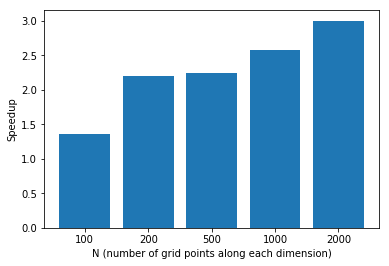

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(5), speedups)
plt.xticks(np.arange(5), [100, 200, 500, 1000, 2000])
plt.xlabel('N (number of grid points along each dimension)')
plt.ylabel('Speedup')

## Example 2: Transient diffusion

In the steady problem, data is only transferred from the CPU to GPU once (before the linear solve), and from GPU to CPU once (after the linear solve). In the transient problem, these copies happen every time step, and it will be interesting to see if this impacts performance.

First, we define the values of the coefficient $D$, the length of the time step $dt$, and the number of time steps to take:

In [20]:
D = 1
dx = 1.
timeStepDuration = 10 * 0.9 * dx**2 / (2 * D)
steps = 100

We define phi as before. For this test, we'll use smaller meshes:

In [21]:
phi = setup_phi(200)

We construct the set of equations that arise from the implicit discretization of the transient diffusion equation:

In [22]:
eq = TransientTerm() == DiffusionTerm(coeff=D)

Now, we march in time by the number of steps defined in `steps`. At each time step, a linear system is solved that gives the updated values of $\phi$.

In [23]:
%%timeit -n1 -r1
for step in range(steps):
    eq.solve(var=phi,
            dt=timeStepDuration)

28.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We visualize the values of $\phi$ after `steps` steps, and examine the value at the center of the domain:

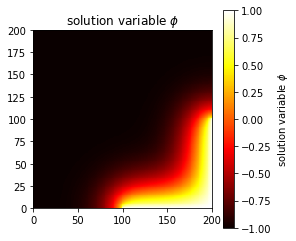

In [24]:
viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='hot')

In [25]:
print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((N/2,), (N/2)))))

Value of phi at (x, y) = (0.5, 0.5): [0.00029121]


Repeat, using the `PyAMGXSolver` solver instead of the default solver:

In [26]:
phi.value = 0

In [27]:
%%timeit -n1 -r1
for step in range(steps):
    eq.solve(var=phi,
            dt=timeStepDuration,
            solver=gmres)

10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


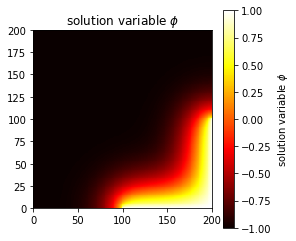

In [28]:
viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='hot')

In [29]:
print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((N/2,), (N/2)))))

Value of phi at (x, y) = (0.5, 0.5): [0.00029121]


We see that both solvers give an identical solution, while the PyAMGXSolver is almost 3 times faster. As with the steady problem, let's plot the speedups obtained for different problem sizes:

In [30]:
import time
default_solver_times = []
pyamgx_solver_times = []

for N in [20, 50, 100, 200, 500]:

    phi = setup_phi(N)
    eq = TransientTerm() == DiffusionTerm(coeff=D)
    
    t1 = time.time()
    for step in range(steps):
        eq.solve(var=phi,
            dt=timeStepDuration)o
    t2 = time.time()
    
    phi.value = 0
    
    t3 = time.time()
    for step in range(steps):
        eq.solve(var=phi,
            dt=timeStepDuration,
            solver=gmres)
    t4 = time.time()
    
    default_solver_times.append(t2-t1)
    pyamgx_solver_times.append(t4-t3)
    print("N = {}".format(N))
    print("\t Time taken by default solver: {}".format(t2-t1))
    print("\t Time taken by pyamgx solver: {}".format(t4-t3))

N = 20
	 Time taken by default solver: 2.46803617477417
	 Time taken by pyamgx solver: 2.570352792739868
N = 50
	 Time taken by default solver: 4.325623035430908
	 Time taken by pyamgx solver: 3.7269644737243652
N = 100
	 Time taken by default solver: 9.443152904510498
	 Time taken by pyamgx solver: 5.097434043884277
N = 200
	 Time taken by default solver: 26.732409954071045
	 Time taken by pyamgx solver: 10.17663860321045
N = 500
	 Time taken by default solver: 128.21260166168213
	 Time taken by pyamgx solver: 41.02032709121704


Text(0,0.5,'Speedup')

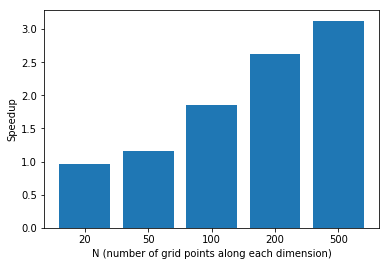

In [31]:
speedups = [n1/n2 for n1, n2 in zip(default_solver_times, pyamgx_solver_times)]

plt.bar(np.arange(5), speedups)
plt.xticks(np.arange(5), [20, 50, 100, 200, 500])
plt.xlabel('N (number of grid points along each dimension)')
plt.ylabel('Speedup')

## Conclusions

FiPy can be accelerated on the GPU using the sparse linear solvers from the AmgX library (via `pyamgx`). For the simple case of 2-d diffusion, this results in a speedup of up to 3x.